In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from PIL import Image
from pathlib import Path
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch, Rectangle


In [2]:
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})


In [3]:
# --- palette + class names ---
COLOR_MAP = {
    0: [0, 0, 0],
    1: [250, 62, 119],
    2: [168, 232, 84],
    3: [242, 180, 92],
    4: [59, 141, 247],
    5: [255, 214, 33],
}

CLASS_NAMES = {
    0: "Background",
    1: "Forest",
    2: "Grassland",
    3: "Cropland",
    4: "Settlement",
    5: "Semi-Natural Grassland",
}


In [4]:
from pathlib import Path
import os

p = Path.cwd().resolve()
for _ in range(10):
    if (p / "data").is_dir() and (p / "scripts").is_dir():
        REPO_ROOT = p
        break
    if p == p.parent:
        raise RuntimeError("Could not find repo root (data/ and scripts/ not found)")
    p = p.parent

os.chdir(REPO_ROOT)
print("Repo root:", REPO_ROOT)

Repo root: /home/lainey/Documents/Github/ClassImbalance


In [5]:
def rgb_percentile_uint8(rgb_float, p_lo=2, p_hi=98, gamma=1.1):
    rgb = rgb_float.astype(np.float32)
    out = np.zeros_like(rgb, dtype=np.float32)
    for c in range(3):
        band = rgb[..., c]
        vals = band[np.isfinite(band)]
        if vals.size == 0:
            continue
        lo, hi = np.percentile(vals, [p_lo, p_hi])
        if hi <= lo:
            continue
        x = (band - lo) / (hi - lo)
        x = np.clip(x, 0, 1)
        x = x ** (1.0 / gamma)
        out[..., c] = np.nan_to_num(x, nan=0.0)
    return (out * 255).round().astype(np.uint8)


def read_rgb_and_mpp(image_tif):
    with rasterio.open(image_tif) as src:
        rgb = np.transpose(src.read([1, 2, 3]).astype(np.float32), (1, 2, 0))
        rgb[~np.isfinite(rgb)] = np.nan

        px = abs(float(src.transform.a))
        if src.crs is not None and src.crs.is_projected:
            mpp_x = px
        else:
            cy = (src.bounds.top + src.bounds.bottom) / 2.0
            mpp_x = px * 111320.0 * np.cos(np.deg2rad(cy))

    return rgb_percentile_uint8(rgb), mpp_x


def read_mask(mask_png):
    mask = np.array(Image.open(mask_png))
    if mask.ndim == 3:
        mask = mask[..., 0]
    return mask


In [6]:
def add_panel_label_above(ax, label):
    ax.text(0.5, 1.02, label, transform=ax.transAxes,
            ha="center", va="bottom", fontsize=12, fontweight="bold")


def add_scale_bar_pixels(ax, img_shape, meters_per_pixel, length_m=100,
                         pad_px=14, bar_height_px=6):
    h, w = img_shape[:2]
    bar_len_px = int(round(length_m / meters_per_pixel))
    bar_len_px = min(bar_len_px, w - 2 * pad_px)
    if bar_len_px < 3:
        return

    x0 = pad_px
    y0 = h - pad_px - bar_height_px
    ax.add_patch(Rectangle((x0, y0), bar_len_px, bar_height_px,
                           facecolor="black", edgecolor="black"))
    ax.text(x0 + bar_len_px / 2, y0 - 5, f"{length_m} m",
            ha="center", va="bottom", fontsize=10,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1))


def add_north_arrow_pixels(ax, img_shape, pad_px=18, size_px=36):
    h, w = img_shape[:2]
    x = w - pad_px
    y = h - pad_px
    ax.annotate("N", xy=(x, y - size_px), xytext=(x, y),
                ha="center", va="center", fontsize=10, fontweight="bold",
                arrowprops=dict(arrowstyle="-|>", linewidth=1.0),
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1))


In [21]:
def plot_fig1(samples, out_png):
    colors = np.array([np.array(COLOR_MAP[i]) / 255.0 for i in range(6)])
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(-0.5, 6.5), cmap.N)

    fig = plt.figure(figsize=(8, 6))
    gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 0.18], hspace=0.30, wspace=0.0)

    top_labels = ["(a)", "(b)", "(c)"]
    bot_labels = ["(d)", "(e)", "(f)"]

    # RGB row
    for j, s in enumerate(samples):
        ax = fig.add_subplot(gs[0, j])
        rgb8, mpp = read_rgb_and_mpp(s["image_tif"])
        ax.imshow(rgb8)
        ax.set_axis_off()
        add_panel_label_above(ax, top_labels[j])
        if j == 0:
            add_scale_bar_pixels(ax, rgb8.shape, mpp)
            add_north_arrow_pixels(ax, rgb8.shape)

    # Mask row
    for j, s in enumerate(samples):
        ax = fig.add_subplot(gs[1, j])
        mask = read_mask(s["mask_png"])
        ax.imshow(mask, cmap=cmap, norm=norm, interpolation="nearest")
        ax.set_axis_off()
        add_panel_label_above(ax, bot_labels[j])

    # Legend
    legend_ax = fig.add_subplot(gs[2, :])
    legend_ax.axis("off")
    handles = [Patch(facecolor=colors[i], label=CLASS_NAMES[i]) for i in range(6)]
    legend_ax.legend(handles=handles, loc="center", ncol=3,
                     frameon=False, fontsize=10)

    #plt.savefig(out_png, dpi=600, bbox_inches="tight", pad_inches=0.02) 
    out_png.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_png.with_suffix(".pdf"), bbox_inches="tight")
    plt.show()

    print("Saved:", out_png)


In [22]:
SAMPLES = [
    {
        "image_tif": REPO_ROOT / "data/biodiversity_raw/images/den4_0004.tif",
        "mask_png":  REPO_ROOT / "data/biodiversity_raw/masks/den4_0004.png",
    },
    {
        "image_tif": REPO_ROOT / "data/biodiversity_raw/images/ireland2_0022.tif",
        "mask_png":  REPO_ROOT / "data/biodiversity_raw/masks/ireland2_0022.png",
    },
    {
        "image_tif": REPO_ROOT / "data/biodiversity_raw/images/col1_0020.tif",
        "mask_png":  REPO_ROOT / "data/biodiversity_raw/masks/col1_0020.png",
    },
]

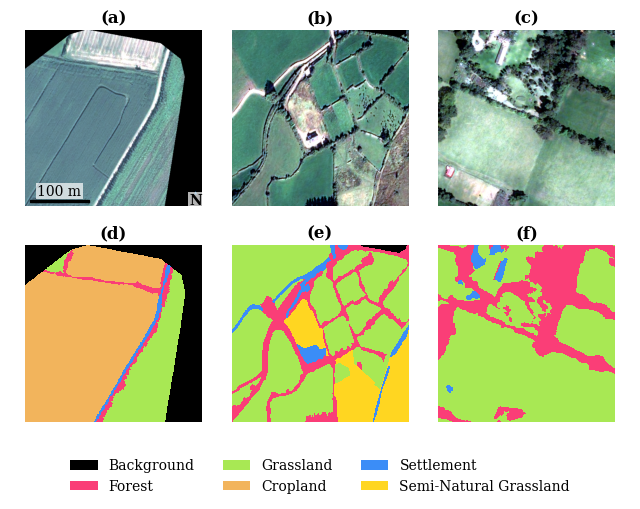

Saved: /home/lainey/Documents/Github/ClassImbalance/outputs/figures/fig1_biodiversity_examples.png


In [ ]:
plot_fig1(
    SAMPLES,
    out_png=REPO_ROOT / "figures/fig1_biodiversity_examples.png"
)